# Clustering Conformations using Python Libraries



In [14]:
import numpy as np
import pickle
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list, to_tree, centroid
from matplotlib import pyplot as plt
from copy import deepcopy
from mpl_toolkits.axisartist.axislines import Subplot
from mpl_toolkits import mplot3d
from sympy.utilities.iterables import multiset_permutations
from pandas import DataFrame as df
from sklearn import decomposition
import pandas as pd
import seaborn as sns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


/var/folders/rf/gvtptwp96wvd1g29v6rqbgj40000gn/T/ipykernel_6044/4225809218.py:16: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


### Testing Accuracy
Passing in already grouped and sorted arrays of the clusters and arrays of the groups derived from annotations, I've implemented two methods to test the accuracy.
The first one is faster using sampling to see which cluster matches which group while the second one attempts to fit all of the permutations of groups to clusters.

#### Note:


In [40]:
def bin_search(arr, l, h, x):
    # Check base case
    if x>arr[h]:
        return False
    if h >= l:
        m = (h+ l) // 2
        if arr[m] == x:
            return True
        elif arr[m] > x:
            return bin_search(arr, l, m- 1, x)
        else:
            return bin_search(arr, m + 1, h, x)
    else:
        return False
def binary_list_elimination(values):
    """Takes in a list of lists and outputs a sublist where all the lists have in common
    n^2logn comparison speed"""
    #print(f"values length: {len(values)}")
    if len(values)== 1:
        return values[0]
    if len(values) == 2:
        out = []
        #print(f"values[1]: {values[1]} values[0]: {values[0]}")
        for i in values[0]:
            if bin_search(values[1],0,len(values[1])-1,i):
                out.append(i)
        return out
    else:
        m = len(values)//2
        l1 = binary_list_elimination(values[:m])
        l2 = binary_list_elimination(values[m:])
        out = l1+ l2
        return binary_list_elimination(out)
def best_fit_elimination(cluster,annotated_dict_list):
    """takes in a single cluster list and annotated_dictionary """
    best_fit_counter_dict = {group: 0 for group in annotated_dict_list}
    for group in annotated_dict_list:
        temp =binary_list_elimination([cluster,annotated_dict_list[group]])
        #print(f"group: {group} temp: {temp}")
        best_fit_counter_dict[group] = len(temp)
    #print(f"best fit counter dict: {best_fit_counter_dict}")
    return best_fit_counter_dict

def micro_avg(matrix,labels):
    """Takes in big matrix along with it's labels and uses one-vs-rest approach to create 
    a list of mini 2x2 micro average matrix and an overall pooled statistics"""
    matrices= list()
    column_sums = np.sum(matrix,axis=0)
    row_sums = np.sum(matrix,axis=1)
    total_sum = np.sum(matrix)
    overall = np.zeros(shape=(2,2))
    for i in range(len(matrix)):
        temp =  np.zeros(shape=(2,2))
        temp[0,0] = matrix[i,i]
        temp[1,0] = column_sums[i] - matrix[i,i]
        temp[0,1] = row_sums[i] - matrix[i,i]
        temp[1,1] = total_sum - row_sums[i] - column_sums[i] + matrix[i , i]
        #print(f"temp: {temp}")
        matrices.append(df(temp.astype(int), index= [f"predicted {labels[i]}", f"predicted not {labels[i]}"], columns= [f"Real {labels[i]}", f"Real not {labels[i]}"]))
        overall = np.add(overall,temp)
    pooled_precision = overall[0,0]/ np.sum(overall, axis = 1)[0]
    pooled_recall = overall[0,0]/ np.sum(overall, axis = 0)[0]
    pooled  = df(overall.astype(int), index= ["predicted", "predicted not "], columns= ["Real", "Real not"]) 
    return matrices, pooled, pooled_precision, pooled_recall
def misclassification(chains_list,cluster_list, annotated_dict_list, most_matched,samples=10):
    """prints misclassified list based on the most_matched order, samples is amount of
    classified samples in the cluster"""
    #print(f"running misclassification, mostmatched[0] {most_matched[0]}")

    print("--"*30+ "\nMISCLASSIFCATION SAMPLES\n"+"--"*30)
    ##sampling 10 mismatches

    for i,label in enumerate(most_matched[0]):
        counter = 0 
        temp = deepcopy(most_matched[0]) #remove the label from the list
        temp.remove(label)
        for conformation in cluster_list[i]:
            if counter > samples:
                break 
            if conformation not in annotated_dict_list[label]:
                counter +=1
                for other_label in temp:
                    if conformation in annotated_dict_list[other_label]:
                        print(f"conformation: {chains_list[conformation]} predicted: {label} real: {other_label}")


    
def statistics(cluster_list, annotated_dict_list):
    """Takes a list of groups unassigned, a dictionary of lists annotated
    where the keys are the groups and the lists are the supposed conformations
    and prints statistics matrix of cross classified conformations:
    where rows correspond to the predictions and columns are the actual"""
    if len(cluster_list) != len(annotated_dict_list):
        print("lengths of clusters and groups must be equal")
        return
    print("--"*30+ "\nSTATISTICS\n" +"--"*30)
    for i in range(len(cluster_list)):
        print(f"cluster {i}, length: {len(cluster_list[i])}")
    a = annotated_dict_list.keys()
    all_permutations=list(multiset_permutations(a))
    fit_list =[best_fit_elimination(cluster,annotated_dict_list) for cluster in cluster_list]
    #permutation indices match cluster_list indices

    ################# PERMUTE FIT

    most_matched = (all_permutations[0],0)
    for permutation in all_permutations:
        #print(f"permutation: {permutation}")
        permutation_matches = 0
        for i in range(len(permutation)):
            #print(f"fit_list[i]: {fit_list[i]}")
            cluster_dict =fit_list[i]
            
            permutation_matches+= cluster_dict[permutation[i]]
        if most_matched[1]< permutation_matches:
            most_matched = (permutation,permutation_matches)
    #print(f"most matched: {most_matched}") #most matched tup[0]: correct permutation where index is cluster index and value is associated group

    ################  CROSS CLASSIFICATION MATRIX

    matrix = np.zeros(shape=(len(cluster_list),len(annotated_dict_list)))
    #most_matched[0] will be asignment order and we assume most_matched[0][0] be the group label for the 0 cluster_list[0]
    for i in range(len(most_matched[0])):
        for j,group2 in enumerate(most_matched[0]):
            matrix[i,j] = fit_list[i][group2]
    #print(f"matrix: {matrix}")


    ################# PRECISION, RECALL, F1

    precision_dict = {key :None for key in most_matched[0]}
    recall_dict = {key :None for key in most_matched[0]}
    
    column_sum =np.sum(matrix,axis=0)
    row_sum= np.sum(matrix, axis =1)
    #print(f"row_sum {row_sum} column_sum: {column_sum}")
    for i in range(len(matrix)):
        #print(f"most_matched[0][i]: {most_matched[0][i]}")
        precision_dict[most_matched[0][i]] = matrix[i,i]/ row_sum[i]
        recall_dict[most_matched[0][i]] = matrix[i,i]/ column_sum[i]
    F1_score_dict = {key: (2*precision_dict[key]*recall_dict[key]/(precision_dict[key] + recall_dict[key])) for key in most_matched[0]}
    p_avg = sum(precision_dict.values())/len(precision_dict)
    r_avg = sum(recall_dict.values())/len(recall_dict)
    f1_avg = sum(F1_score_dict.values())/len(F1_score_dict)
    stats_mat = list()
    for i,key in enumerate(most_matched[0]):
        stats_mat.append([precision_dict[key],recall_dict[key],F1_score_dict[key]])
        if i == len(most_matched[0])-1:
            stats_mat.append([p_avg,r_avg,f1_avg])
    #print(f"stats mat:\n {stats_mat}")
    stats_df = df(stats_mat,most_matched[0] + ["Averages"], ["Precision", "Recall", "F1 score"])
    micro_averages, pooled, pooled_precision,pooled_recall= micro_avg(matrix,most_matched[0])

    ############## MACRO AVERAGES

    print("--"*30+ "\nMACRO AVERAGES\n" +"--"*30)
    #print(f"precision: {precision_dict}\nmacro average: {p_avg}\nrecall: {recall_dict}\nmacro average: {r_avg}\nF1 score: {F1_score_dict}\nmacro average:{f1_avg}")
    print(stats_df.to_string(max_cols=3))
    out = df(matrix.astype(int), ["Predicted "+label for label in most_matched[0]] ,["Real "+label for label in most_matched[0]])
    print(f"out:\n {out.to_string(max_cols=len(most_matched[0]))}")


    ############## MICRO AVERAGES

    print("--"*30+ "\nMICRO AVERAGES\n"+"--"*30)
    #print(f"len mic_avg: {len(micro_averages)}")
    for m_avg in micro_averages:
        print(f"{m_avg}")

    print(f"pooled:\n {pooled}")
    
    print(f"precision: {pooled_precision} recall: {pooled_recall}")
    print(f"F1_score: {2*pooled_precision*pooled_recall/(pooled_precision+pooled_recall)}")
    
    return most_matched



In [52]:
df([[2,3],[4,5],[24,3]])

0  1
0  2   3
1  4   5
2  24  3

In [3]:
def heat_map(leaves_list,chains_list,matrix):
    """Prints heat map where rows are ordered by the clustering algorithm,
    columns are still chains list ordered"""
    rows = [chains_list[i] for i in leaves_list]
    ordered_mat = [matrix[i] for i in leaves_list]
    #print(f"rows: {rows}, chains_list {chains_list}")
    heat_frame = df(ordered_mat,rows,chains_list)
    print(f"starting heat function 2")
    #f, ax = plt.subplots(figsize=(11, 9))
    #cmap = sns.diverging_palette(230, 20, as_cmap=True)
    plt.figure(figsize=(1000,1000))
    plt.xticks(range(len(chains_list)),chains_list,rotation=90)
    plt.yticks(range(len(rows)),rows)
    plt.imshow(heat_frame, cmap='hot',interpolation="nearest")

In [6]:
def plot_pca(matrix,dimension,chains_list):
    if dimension > 3 or dimension <1:
        print("invalid dimension")
        return 
    np.matrix(matrix)
    pca = decomposition.PCA(n_components=dimension)
    reduced_matrix=pca.fit_transform(matrix)
    print(f"shape reduced matrix: {np.shape(reduced_matrix)}")
    #print(reduced_matrix)
    #just in case
    
    axes =reduced_matrix.T
    print(f"axes[0][0]: {axes[0][0]} matrix.T: {reduced_matrix.T}")
    
    #plt.scatter(axes[0].tolist(),axes[1].tolist())
    #Plot the matrix and annotate it.
    if dimension == 2:
        plt.figure(figsize=(20,20))
        axis1 =axes[0].tolist()
        axis2 =axes[1].tolist()
        plt.scatter(axis1,axis2)
        for i,label in enumerate(chains_list):
            plt.annotate(label, (axis1[i], axis2[i]))
    return reduced_matrix

shape reduced matrix: (4, 2)
axes[0][0]: -0.590170298207794 matrix.T: [[-0.5901703  -1.85737267  4.30491563 -1.85737267]
 [ 0.84510296 -0.33565872 -0.17378552 -0.33565872]]


array([[-0.5901703 ,  0.84510296],
       [-1.85737267, -0.33565872],
       [ 4.30491563, -0.17378552],
       [-1.85737267, -0.33565872]])

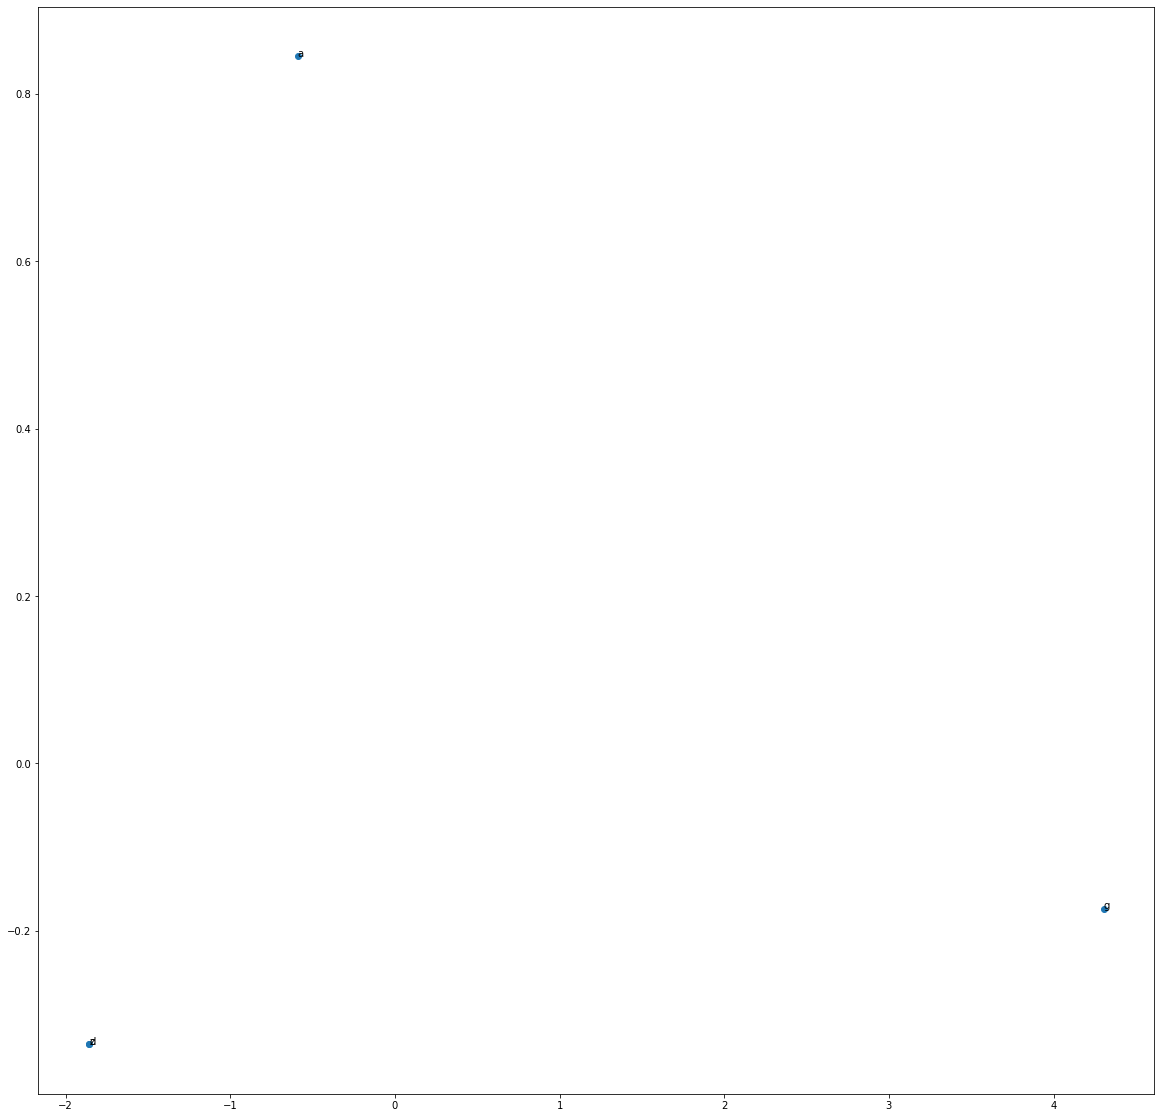

In [7]:
mat = np.matrix([[3,4,5],[2,3,4],[3,4,10],[2,3,4]])
input_list = ["a","d", "g", "z"]
plot_pca(mat,2,input_list)

In [42]:
sublist = [0,3,4,5,6,11,12]
full_list =[1,2,4,6,20,23,0,3,8,9,11,5,7,10,12,13,14,15]
grouped_list = [[1,2,4,6,20,23],[0,3,8,9,11],[5,7,10,12,13,14,15]]
annotated_dict_list_test = {"a": [1,2,7,20,13,14,15], "b": [0,3,5,8,9,10], "c": [4,6,11,12,23]}
#print(f"iter items: {annotated_dict_list.items()}")
#print(f"best fit sampling: {best_fit_sample(sublist, annotated_dict_list)}")
#print(f"best fit elimination: {best_fit_elimination(sublist, annotated_dict_list)}")
most_matched =statistics(grouped_list,annotated_dict_list_test)
misclassification(full_list, grouped_list, annotated_dict_list_test, most_matched)
#the problem is that not all of the samples are in the grouped list and neither the other way around so the percision and recall values might be messed up

------------------------------------------------------------
STATISTICS
------------------------------------------------------------
cluster 0, length: 6
cluster 1, length: 5
cluster 2, length: 7
------------------------------------------------------------
MACRO AVERAGES
------------------------------------------------------------
          Precision    Recall  F1 score
c              0.60  0.600000  0.600000
b              0.80  0.666667  0.727273
a              0.25  0.333333  0.285714
Averages       0.55  0.533333  0.537662
out:
              Real c  Real b  Real a
Predicted c       3       0       2
Predicted b       1       4       0
Predicted a       1       2       1
------------------------------------------------------------
MICRO AVERAGES
------------------------------------------------------------
                 Real c  Real not c
predicted c      3       2         
predicted not c  2       7         
                 Real b  Real not b
predicted b      4       1         


IndexError: list index out of range

## Load presorted classification based on annotations list

In [11]:
#@ open files
with open("chains_list.var","rb") as chains_list_var:
   chains_list = pickle.load(chains_list_var)
   chains_list_var.close()
#print(f"chains_list: {chains_list}")
with open("structures/opened_active.var", "rb") as open_active_var:
    open_active_list = pickle.load(open_active_var)
    open_active_var.close()
with open("structures/closed_inactive.var", "rb") as closed_inactive_var:
    closed_inactive_list = pickle.load(closed_inactive_var)
    closed_inactive_var.close()
with open("structures/opened_inactive.var", "rb") as open_inactive_var:
    open_inactive_list = pickle.load(open_inactive_var)
    open_inactive_var.close()

print(f"open_active: {len(open_active_list)}")
print(f"closed_inactive: {len(closed_inactive_list)}")
print(f"open_inactive: {len(open_inactive_list)}")
annotated_dict_list_codes= {"open_active": open_active_list, "closed_inactive": closed_inactive_list, "open_inactive": open_inactive_list} #dictionary of codes list
annotated_dict_list ={"open_active": list(), "closed_inactive": list(), "open_inactive": list()} #dictionary of list of indices
for i,conformation in enumerate(chains_list):
    for j,l in enumerate(annotated_dict_list_codes):
        if conformation in annotated_dict_list_codes[l]:
            #print(f"l: {l}")
            annotated_dict_list[l].append(i)
#print(f"annotated_dict_list: {annotated_dict_list}")




open_active: 162
closed_inactive: 277
open_inactive: 92


### Open calculated rms matrix and chains list
#### matrix.var
Calculated rms matrix from aligning all of the choice conformation chosen by best_align.py and calculated by pml_script_all.py.
#### chains_list.var
Generated by reading through the dictionary of annotated conformations and making a list of chains of the conformation. This will give the labeling order of the rms matrix obtained since pml_script_all.py iterated through this list

In [10]:
with open("matrix.var", "rb") as matrix_var:
   matrix = (pickle.load(matrix_var))
#print(f"matrix: {matrix}")
with open("matrix_AB.var", "rb") as matrix_AB_var:
   matrix_AB = (pickle.load(matrix_AB_var))

## PCA reduction to 2 dimensions of the RMSD matrix

shape reduced matrix: (531, 2)
axes[0][0]: 135.7602066730161 matrix.T: [[135.76020667  70.5133525   70.94308717 ... -26.26900724 149.23928136
  149.42811057]
 [ 31.05728639 -58.3650935  -58.21254237 ... -22.97875411  36.4308554
   36.64528995]]


array([[135.76020667,  31.05728639],
       [ 70.5133525 , -58.3650935 ],
       [ 70.94308717, -58.21254237],
       ...,
       [-26.26900724, -22.97875411],
       [149.23928136,  36.4308554 ],
       [149.42811057,  36.64528995]])

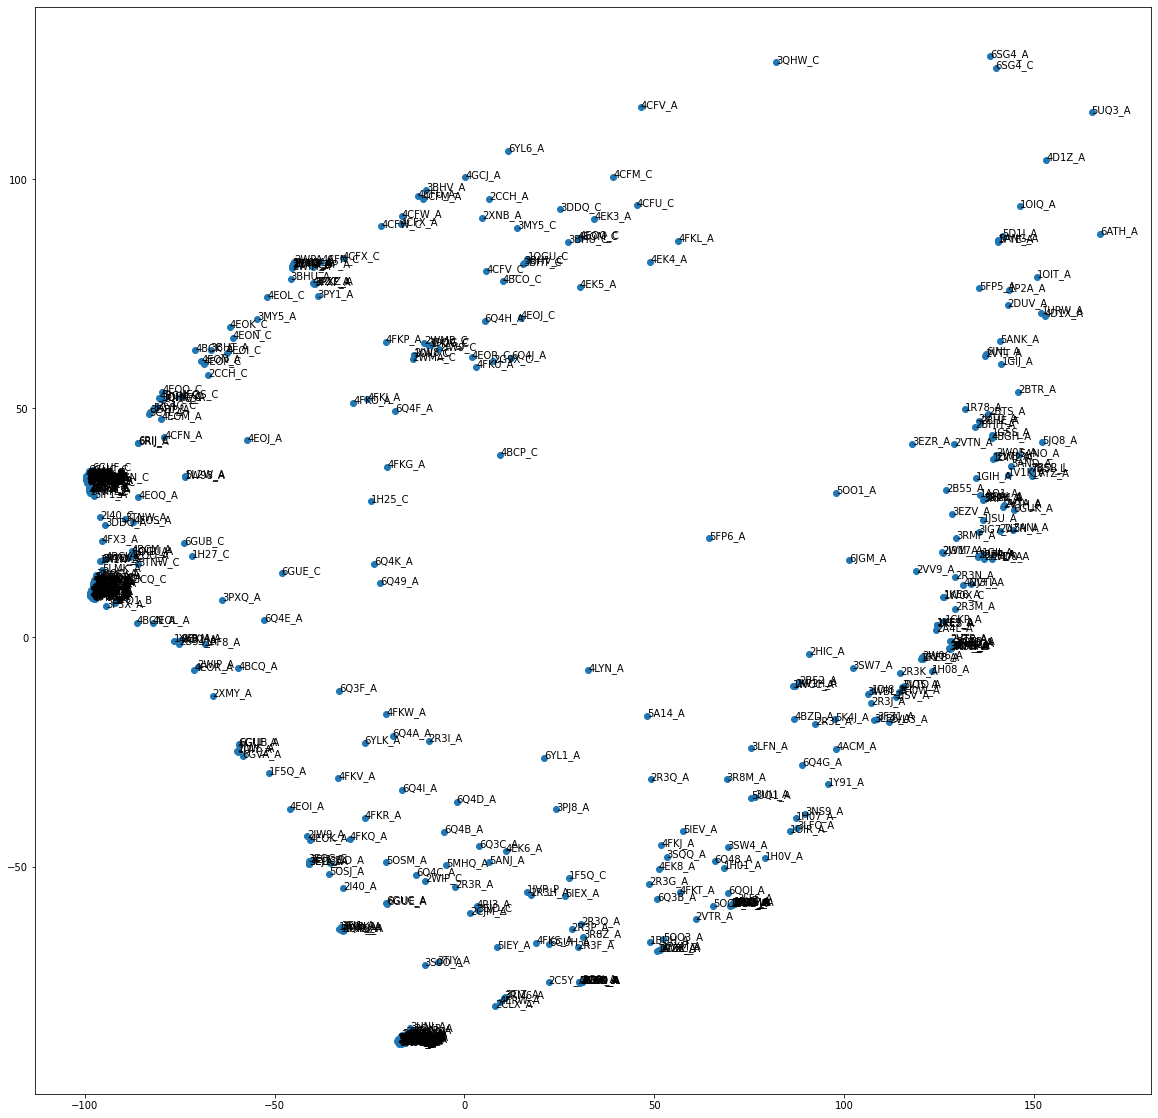

In [12]:
plot_pca(matrix,2,chains_list)

## Hierarchical clustering algorithms using Scipy
These algorithms rely on a distance matrix computed at each iteration.
$d[i,j]$ is distance between cluster _i_ and _j_ in the original forest
We also define clusters _s_, _t_, _u_ formed from _s_ and _t_ which are then removed as _u_ is added to the forest. Finally we introduce cluster _v_ a cluster that is not _u_ unused after the formation of _u_.

### Ward's Algorithm
A linkage with minimum variance method. We define 
$$
T = |v| + |s| + |t|
$$
As the cardinality the forest _u_ and _v_ combined
Given the distance function is computed recursively with the equation:
$$
d[i][j] = d(i,j) = \sqrt{\frac{|v| + |s|}{T}d(v,s)^2 + \frac{|v| + |t|}{T}d(v,t)^2 - \frac{|v|}{T}d(s,t)^2}
$$
The merging cost, of which ward's algorithm tries to minimize the growth is defined as follows:
$$
Cost(u,v) = \frac{|u||v|}{|u| +|v|}||c_u - c_v ||^2
$$
$c_i$ is the vector of the centroid. And the derivation comes from the distance sum union of the two sets together minus the distance sum of the individual sets. 
<br>
It considers the case of merging and then calculates the variance from the centroid of the final merged cluster as the distance


### Ward's algorithm CA alpha RMSD matrix:

/var/folders/rf/gvtptwp96wvd1g29v6rqbgj40000gn/T/ipykernel_6044/2971858723.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out_ward = linkage(matrix, 'ward')


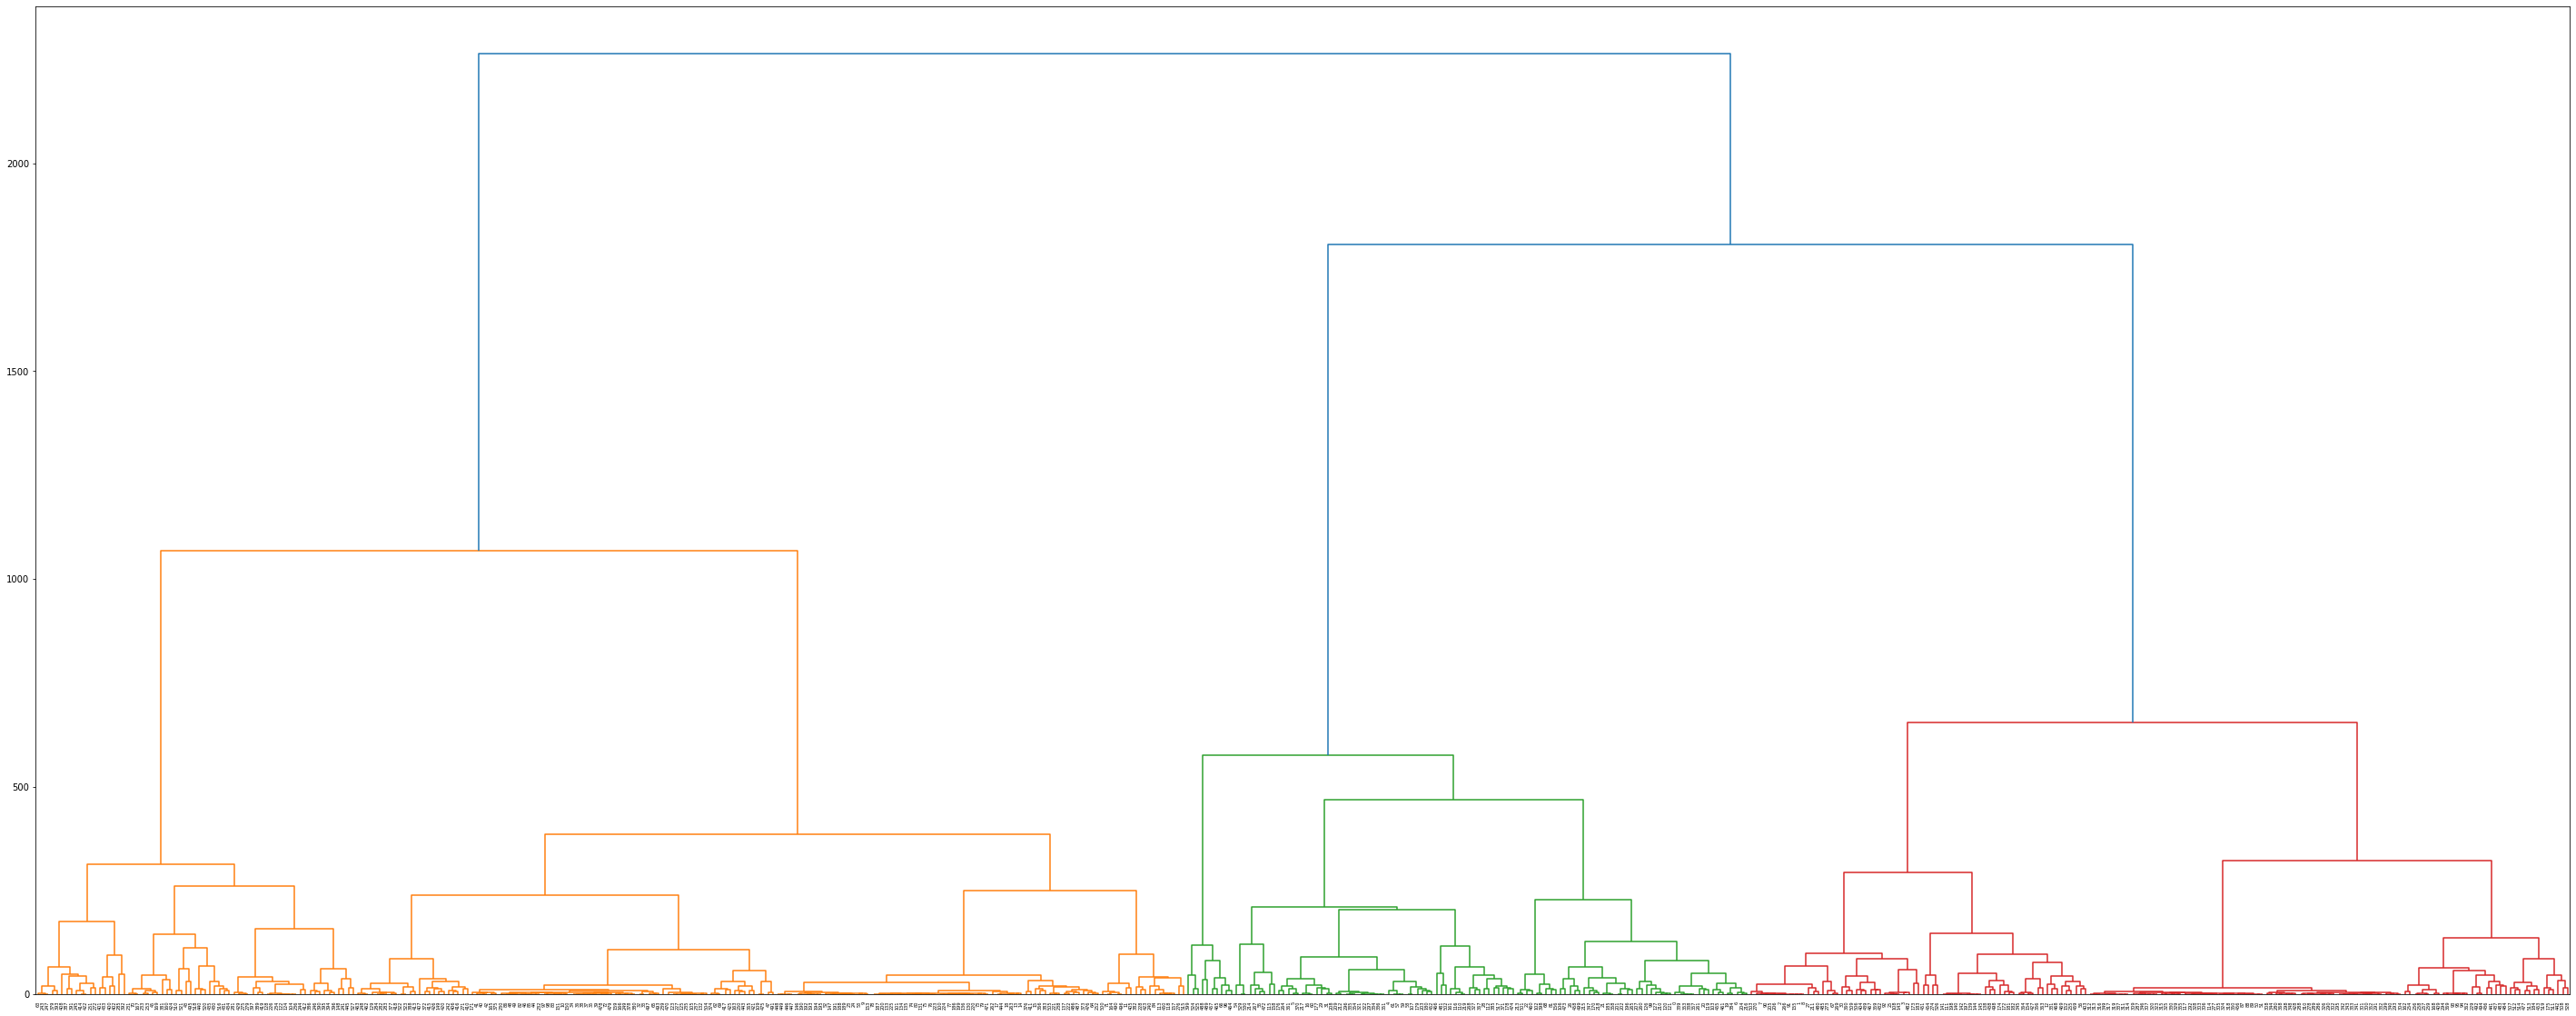

In [38]:
#print(f"len matrix: {len(matrix)}")
out_ward = linkage(matrix, 'ward')
fig = plt.figure(figsize=(50,20))
dn = dendrogram(out_ward)


In [44]:
l = leaves_list(out_ward)
#print(f"l: {l}")
tree = to_tree(out_ward)
##############################
#Split the trees into usable groups
yellow_tree = tree.get_left()
green_tree = tree.get_right().get_left()
red_tree = tree.get_right().get_right()
idx1= yellow_tree.count
idx2= idx1+green_tree.count
grouped_list_ward = [np.sort(l[:idx1]),np.sort(l[idx1:idx2]),np.sort(l[idx2:])]
n = tree.count
#print(f"grouped_list: {grouped_list}")
most_matched =statistics(grouped_list_ward,annotated_dict_list)
misclassification(chains_list, grouped_list_ward, annotated_dict_list, most_matched)

#maybe 3x3 matrix to evaluate the misclassification in the two other groups #multiclass precision, accuracy, F-score

------------------------------------------------------------
STATISTICS
------------------------------------------------------------
cluster 0, length: 241
cluster 1, length: 118
cluster 2, length: 172
------------------------------------------------------------
MACRO AVERAGES
------------------------------------------------------------
                 Precision    Recall  F1 score
open_active       0.626556  0.932099  0.749380
open_inactive     0.135593  0.173913  0.152381
closed_inactive   0.872093  0.541516  0.668151
Averages          0.544747  0.549176  0.523304
out:
                            Real open_active  Real open_inactive  Real closed_inactive
Predicted open_active                   151                  59                    31
Predicted open_inactive                   6                  16                    96
Predicted closed_inactive                 5                  17                   150
------------------------------------------------------------
MICRO AVERAGES


### RMSD Matrix Heat Map

len l: 531 max l: 530 chains list length: 531
starting heat function 2


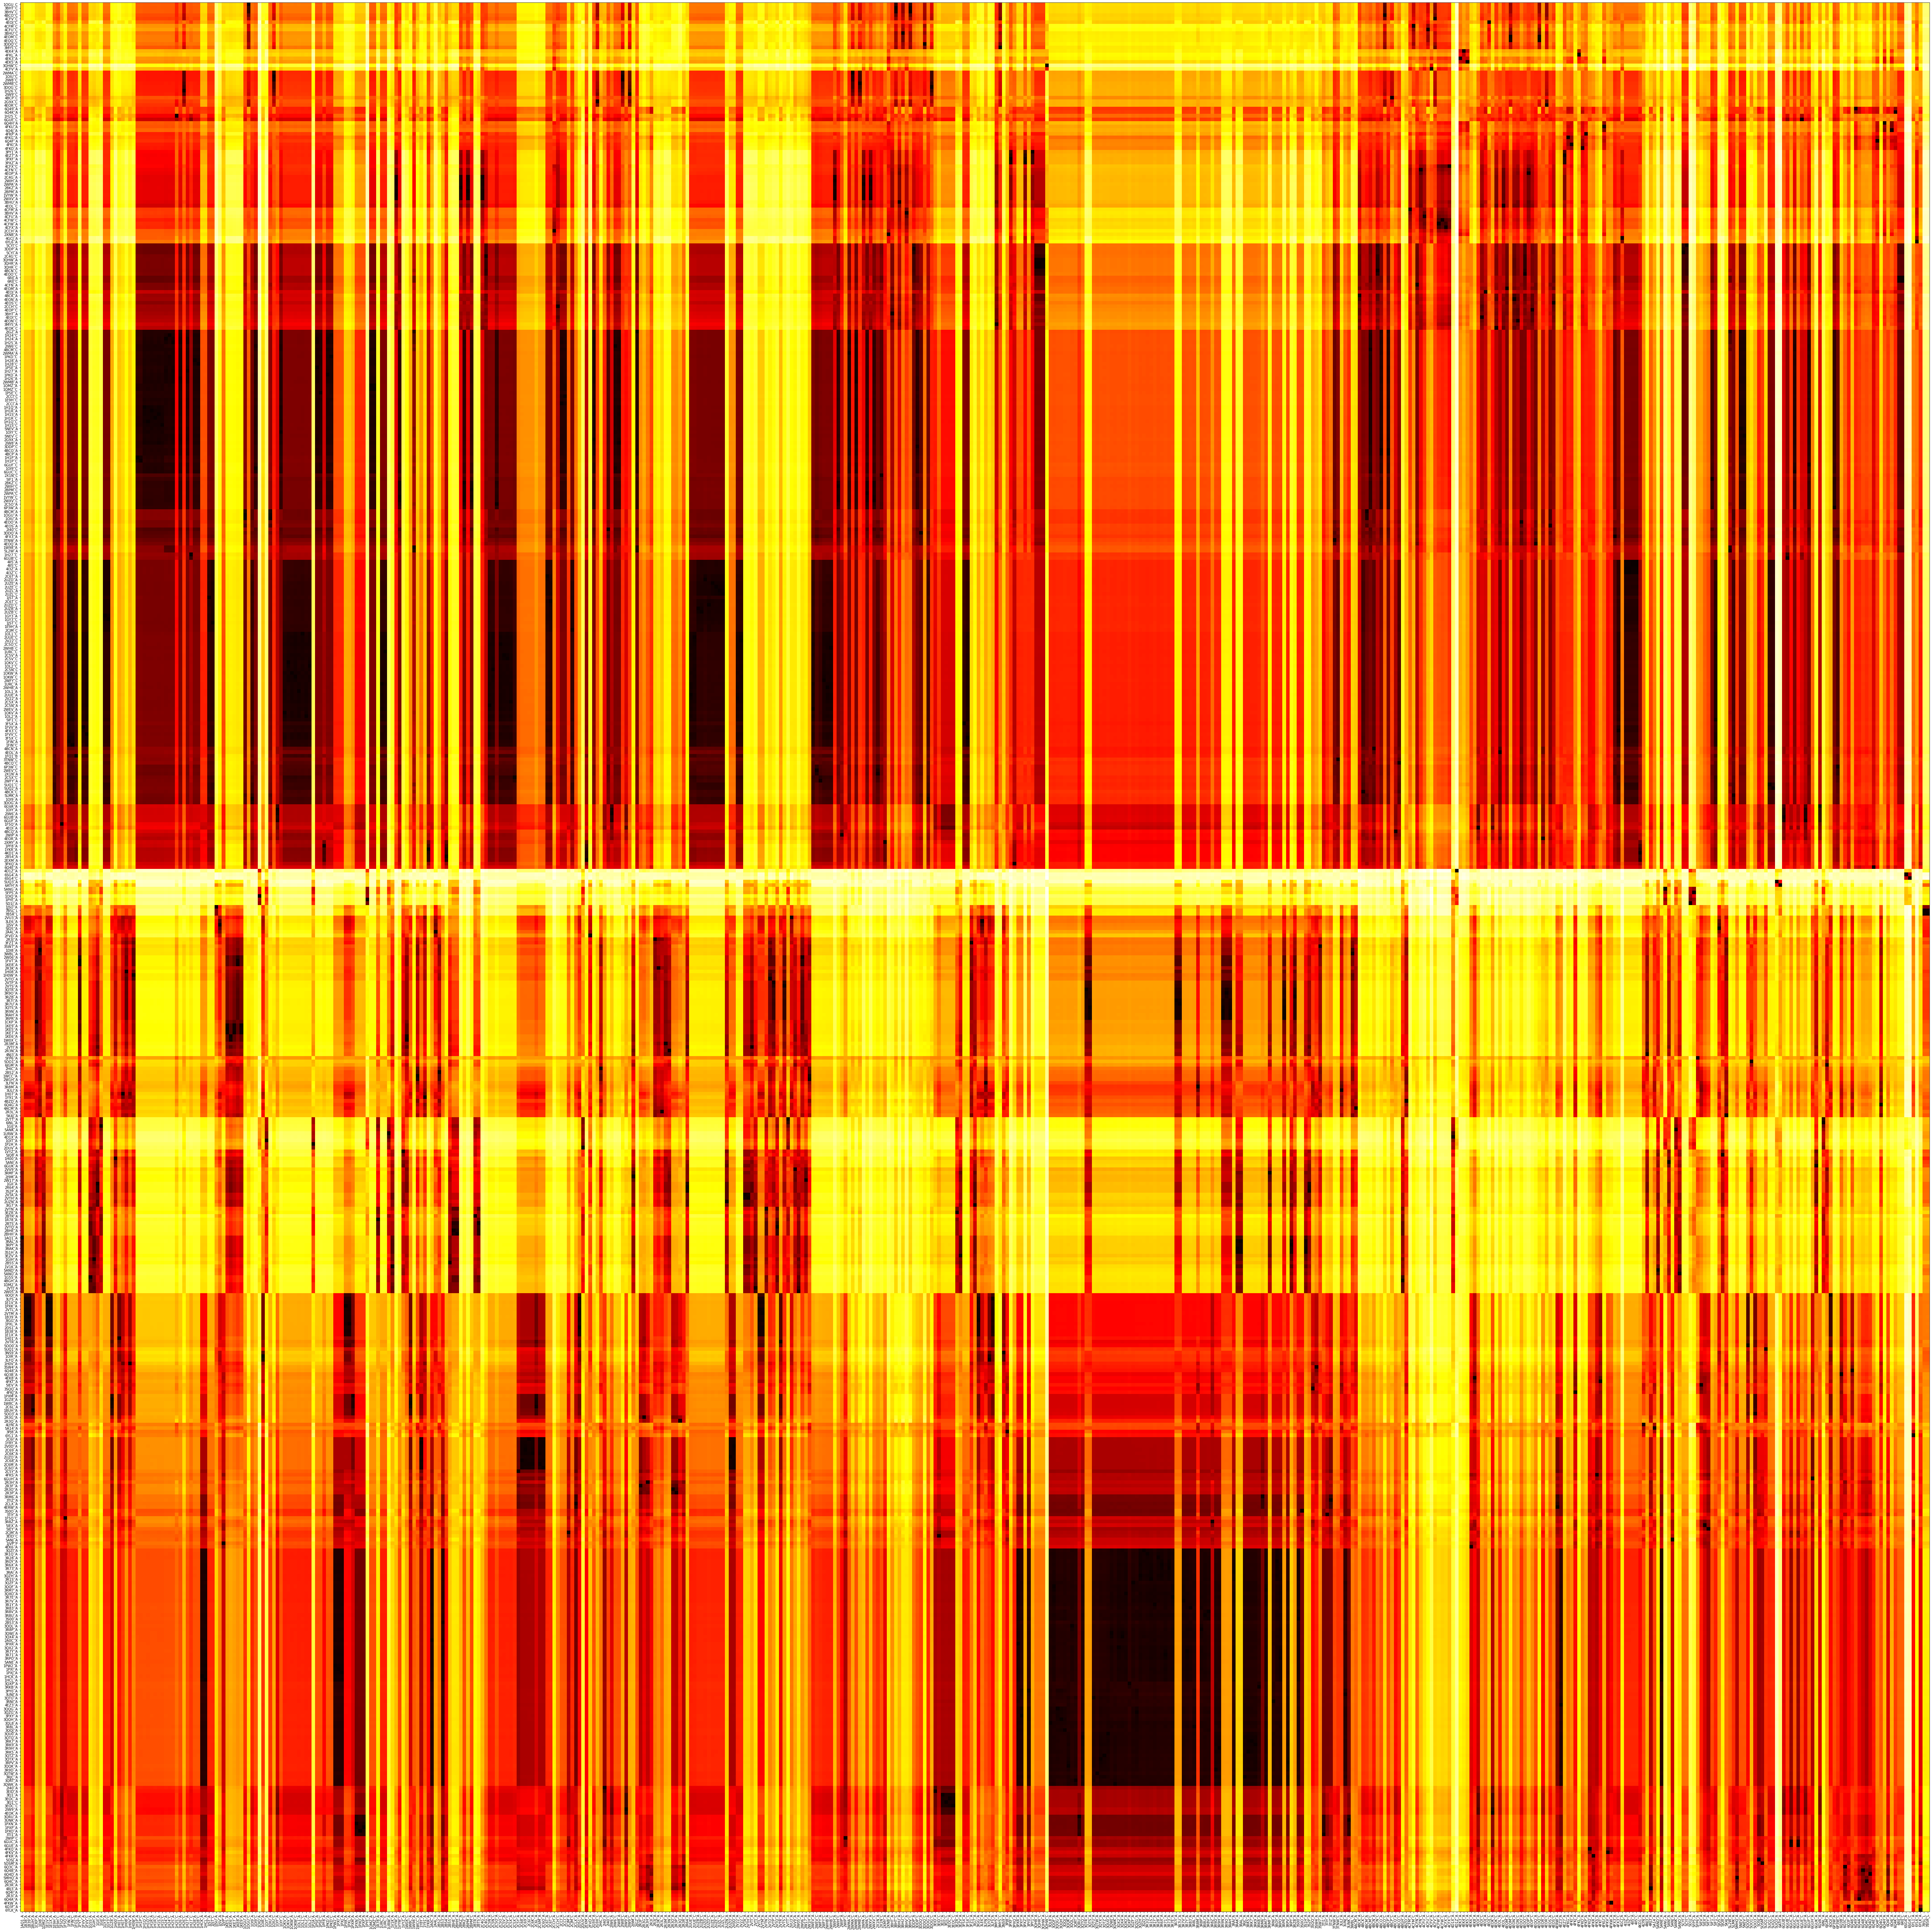

In [73]:
print(f"len l: {len(l)} max l: {max(l)} chains list length: {len(chains_list)}")
heat_map(l,chains_list,matrix)

### Ward's algorithm CA and CB RMSD Matrix

/var/folders/rf/gvtptwp96wvd1g29v6rqbgj40000gn/T/ipykernel_5529/3909946644.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out_ward_AB = linkage(matrix_AB, 'ward')


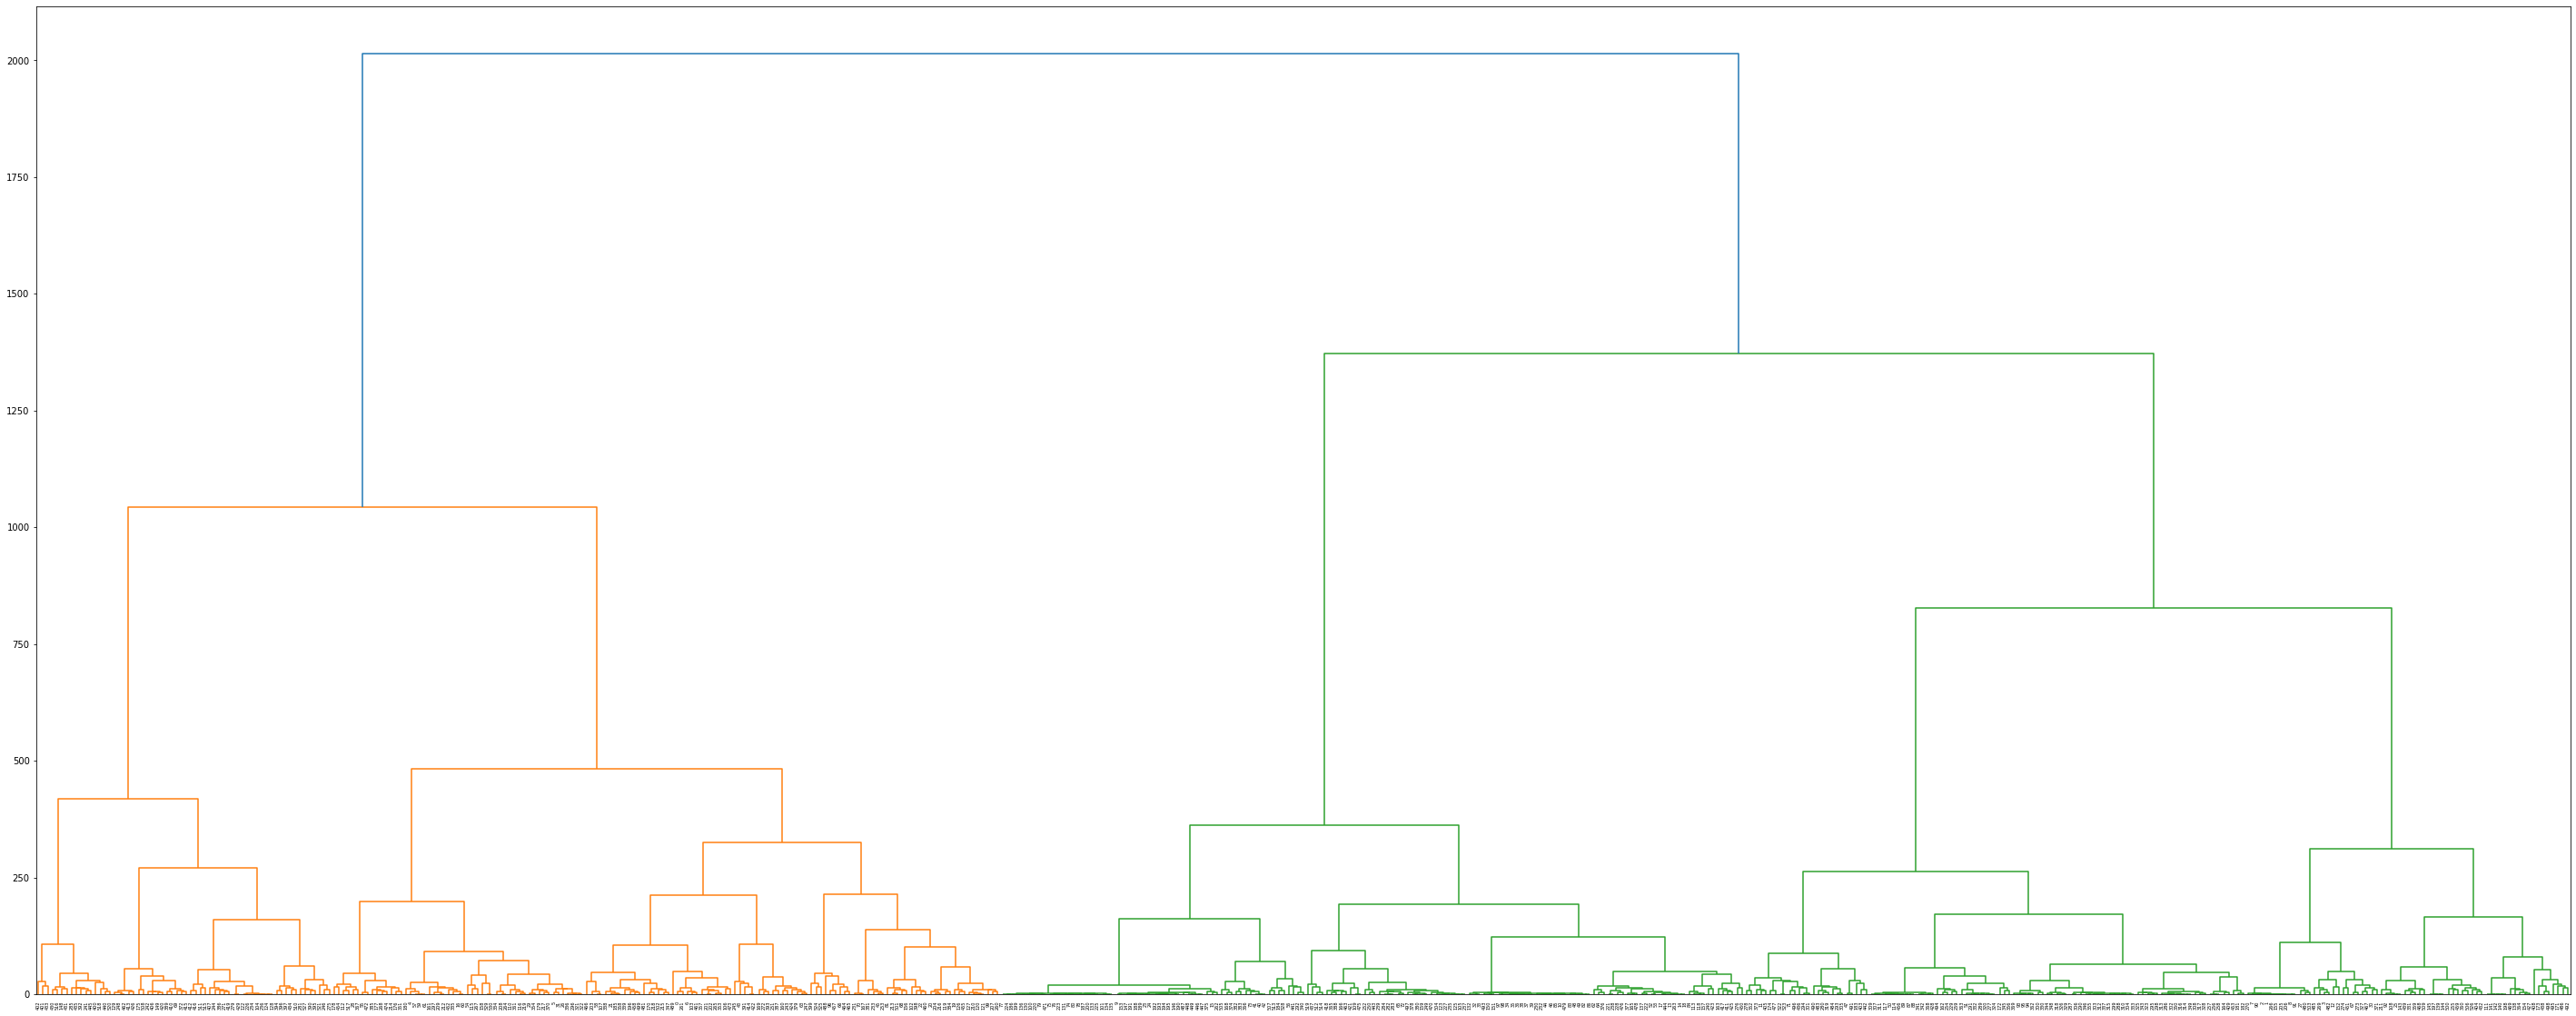

In [14]:
out_ward_AB = linkage(matrix_AB, 'ward')
fig = plt.figure(figsize=(50,20))
dn = dendrogram(out_ward_AB)

In [15]:
l = leaves_list(out_ward_AB)
tree = to_tree(out_ward_AB)
##############################
#Split the trees into usable groups
yellow_tree = tree.get_left()
green_tree = tree.get_right().get_left()
red_tree = tree.get_right().get_right()
idx1= yellow_tree.count
idx2= idx1+green_tree.count
grouped_list_ward_AB = [np.sort(l[:idx1]),np.sort(l[idx1:idx2]),np.sort(l[idx2:])]
n = tree.count
#print(f"grouped_list: {grouped_list}")
statistics(grouped_list_ward_AB,annotated_dict_list)

------------------------------------------------------------
STATISTICS
------------------------------------------------------------
cluster 0, length: 202
cluster 1, length: 156
cluster 2, length: 173
------------------------------------------------------------
MACRO AVERAGES
------------------------------------------------------------
                 Precision    Recall  F1 score
open_inactive     0.118812  0.260870  0.163265
open_active       0.551282  0.530864  0.540881
closed_inactive   0.791908  0.494585  0.608889
Averages          0.487334  0.428773  0.437678
out:
                            Real open_inactive  Real open_active  Real closed_inactive
Predicted open_inactive                    24                58                   120
Predicted open_active                      50                86                    20
Predicted closed_inactive                  18                18                   137
------------------------------------------------------------
MICRO AVERAGES


## Average Linkage: CA

/var/folders/rf/gvtptwp96wvd1g29v6rqbgj40000gn/T/ipykernel_5529/3184923608.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out_average = linkage(matrix, 'average')


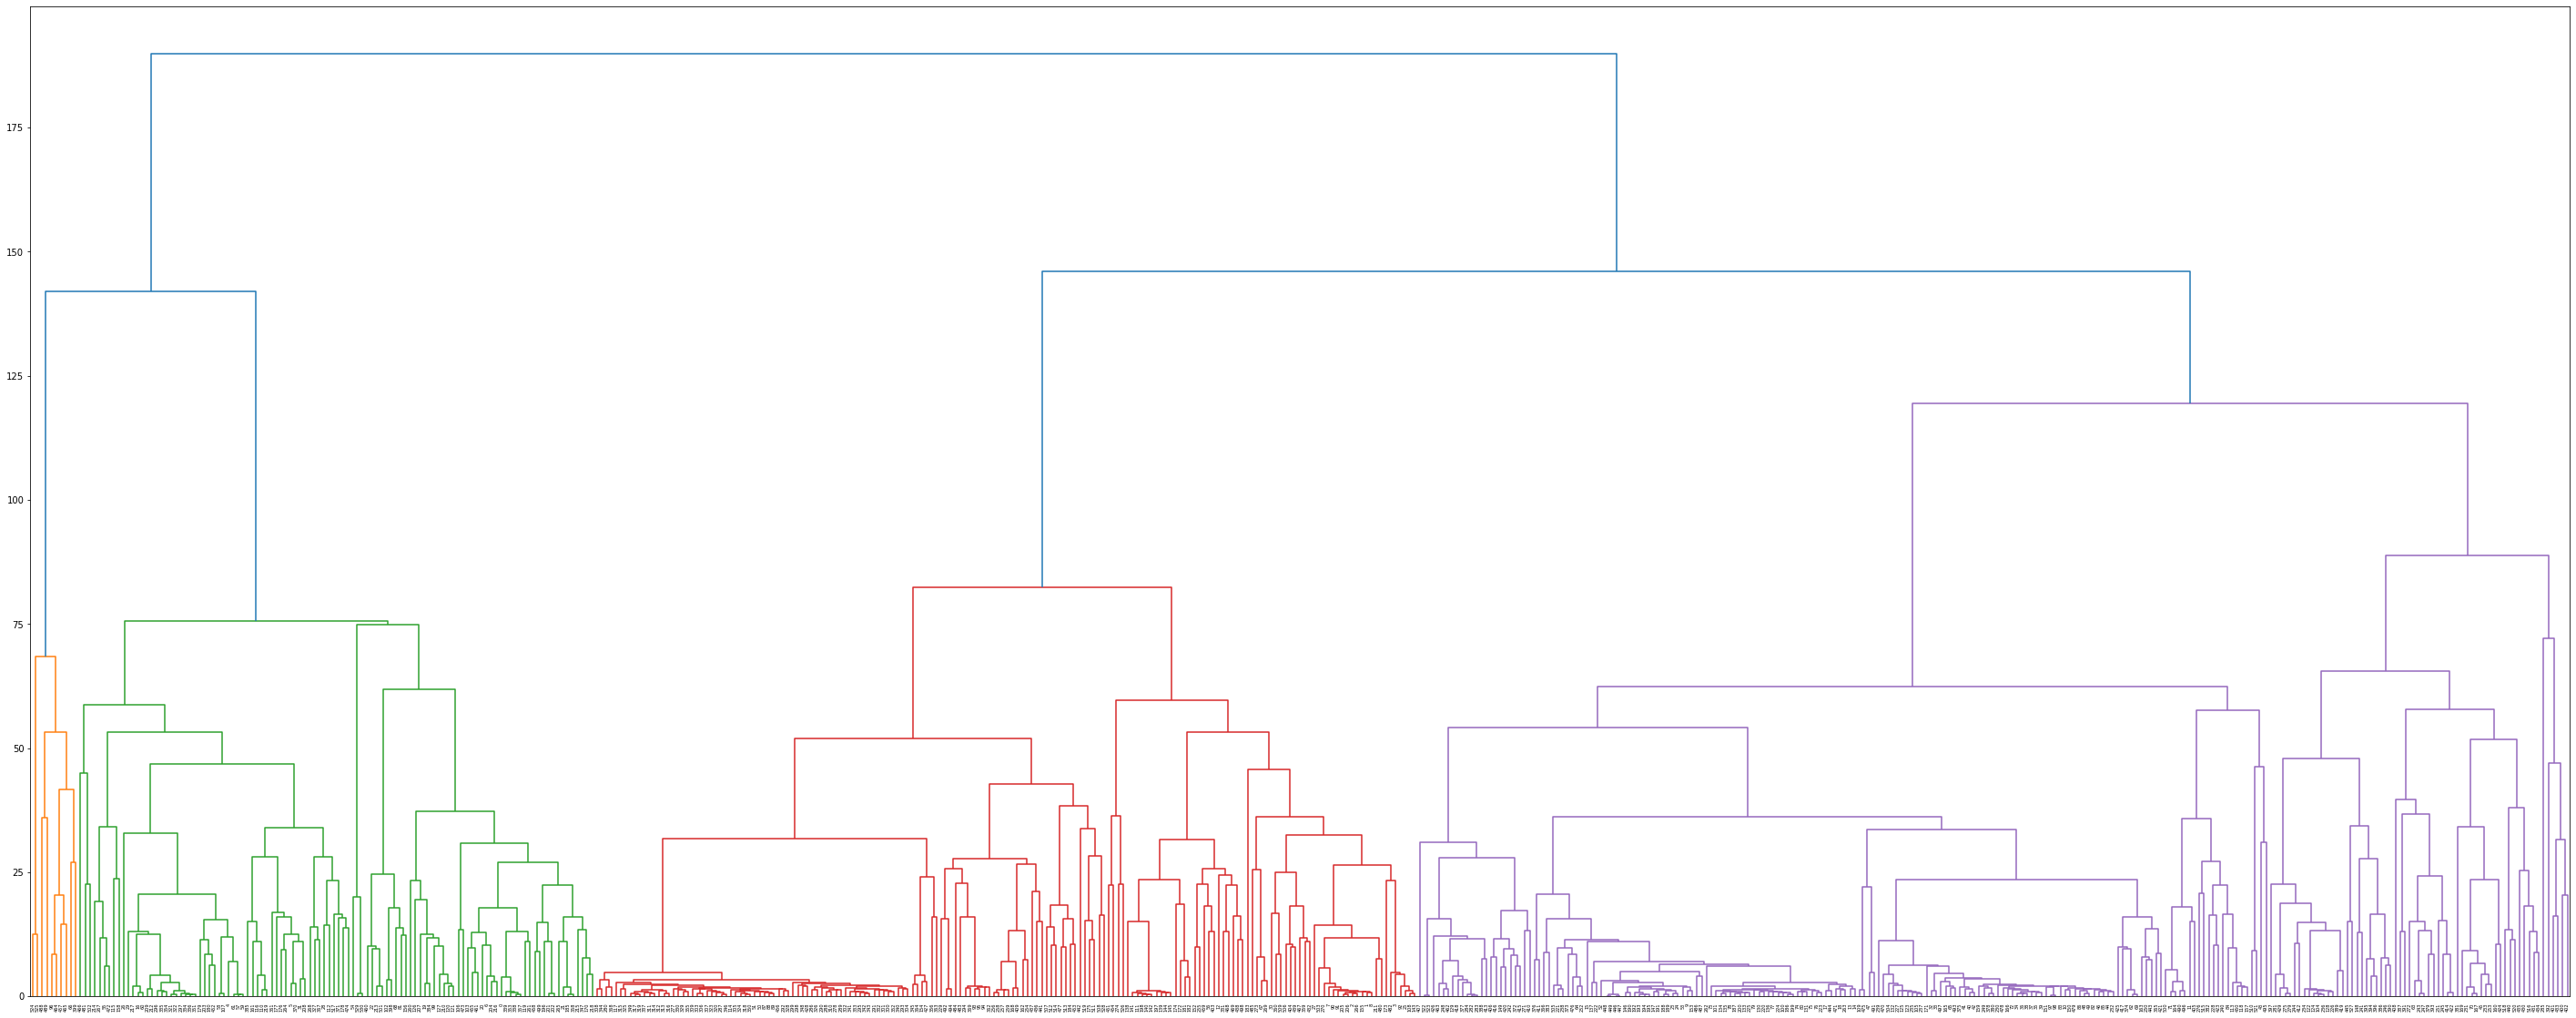

In [16]:
out_average = linkage(matrix, 'average')
fig = plt.figure(figsize=(50,20))
dn = dendrogram(out_average)

In [17]:
l = leaves_list(out_average)
tree = to_tree(out_average)
##############################
#Split the trees into usable groups
tree1 = tree.get_left()
tree2 = tree.get_right().get_left()
tree3 = tree.get_right().get_right()
idx1= tree1.count
idx2= idx1+tree2.count
grouped_list_average = [np.sort(l[:idx1]),np.sort(l[idx1:idx2]),np.sort(l[idx2:])]
n = tree.count
#print(f"grouped_list: {grouped_list}")
statistics(grouped_list_average,annotated_dict_list)


------------------------------------------------------------
STATISTICS
------------------------------------------------------------
cluster 0, length: 118
cluster 1, length: 172
cluster 2, length: 241
------------------------------------------------------------
MACRO AVERAGES
------------------------------------------------------------
                 Precision    Recall  F1 score
open_inactive     0.135593  0.173913  0.152381
closed_inactive   0.872093  0.541516  0.668151
open_active       0.626556  0.932099  0.749380
Averages          0.544747  0.549176  0.523304
out:
                            Real open_inactive  Real closed_inactive  Real open_active
Predicted open_inactive                    16                    96                 6
Predicted closed_inactive                  17                   150                 5
Predicted open_active                      59                    31               151
------------------------------------------------------------
MICRO AVERAGES


### Average Linkage CA + CB

/var/folders/rf/gvtptwp96wvd1g29v6rqbgj40000gn/T/ipykernel_5529/2534781170.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out_average_AB = linkage(matrix_AB, 'average')


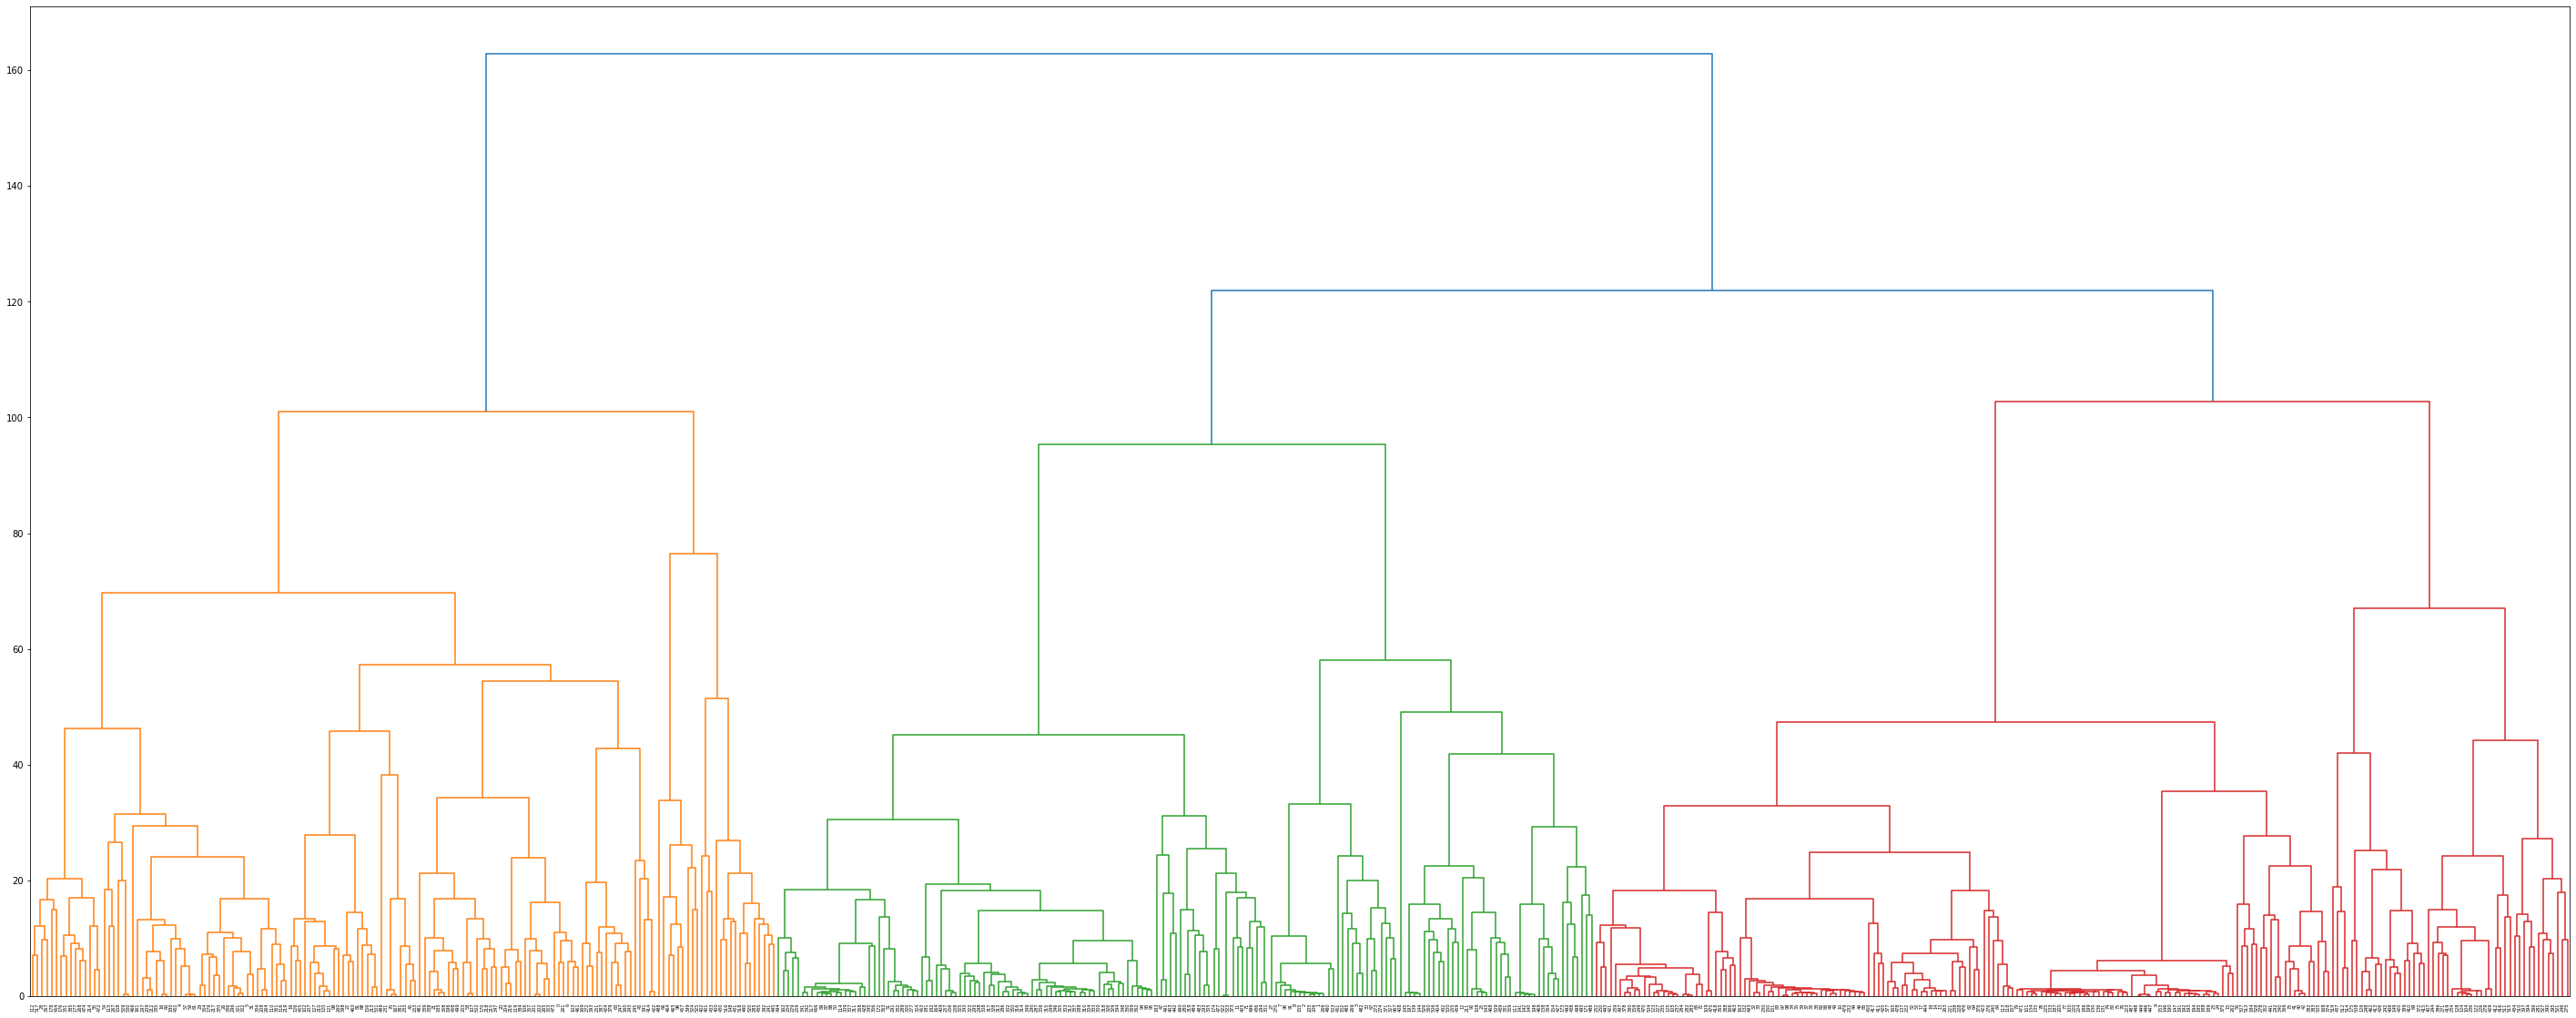

In [18]:
out_average_AB = linkage(matrix_AB, 'average')
fig = plt.figure(figsize=(50,20))
dn = dendrogram(out_average_AB)

In [19]:
l = leaves_list(out_average_AB)
tree = to_tree(out_average_AB)
##############################
#Split the trees into usable groups
tree1 = tree.get_left()
tree2 = tree.get_right().get_left()
tree3 = tree.get_right().get_right()
idx1= tree1.count
idx2= idx1+tree2.count
grouped_list_average = [np.sort(l[:idx1]),np.sort(l[idx1:idx2]),np.sort(l[idx2:])]
n = tree.count
#print(f"grouped_list: {grouped_list}")
statistics(grouped_list_average,annotated_dict_list)

------------------------------------------------------------
STATISTICS
------------------------------------------------------------
cluster 0, length: 156
cluster 1, length: 171
cluster 2, length: 204
------------------------------------------------------------
MACRO AVERAGES
------------------------------------------------------------
                 Precision    Recall  F1 score
open_inactive     0.102564  0.173913  0.129032
closed_inactive   0.789474  0.487365  0.602679
open_active       0.549020  0.691358  0.612022
Averages          0.480352  0.450879  0.447911
out:
                            Real open_inactive  Real closed_inactive  Real open_active
Predicted open_inactive                    16                   108                32
Predicted closed_inactive                  18                   135                18
Predicted open_active                      58                    34               112
------------------------------------------------------------
MICRO AVERAGES


## Centroid CA

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:633: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='centroid', metric='euclidean')


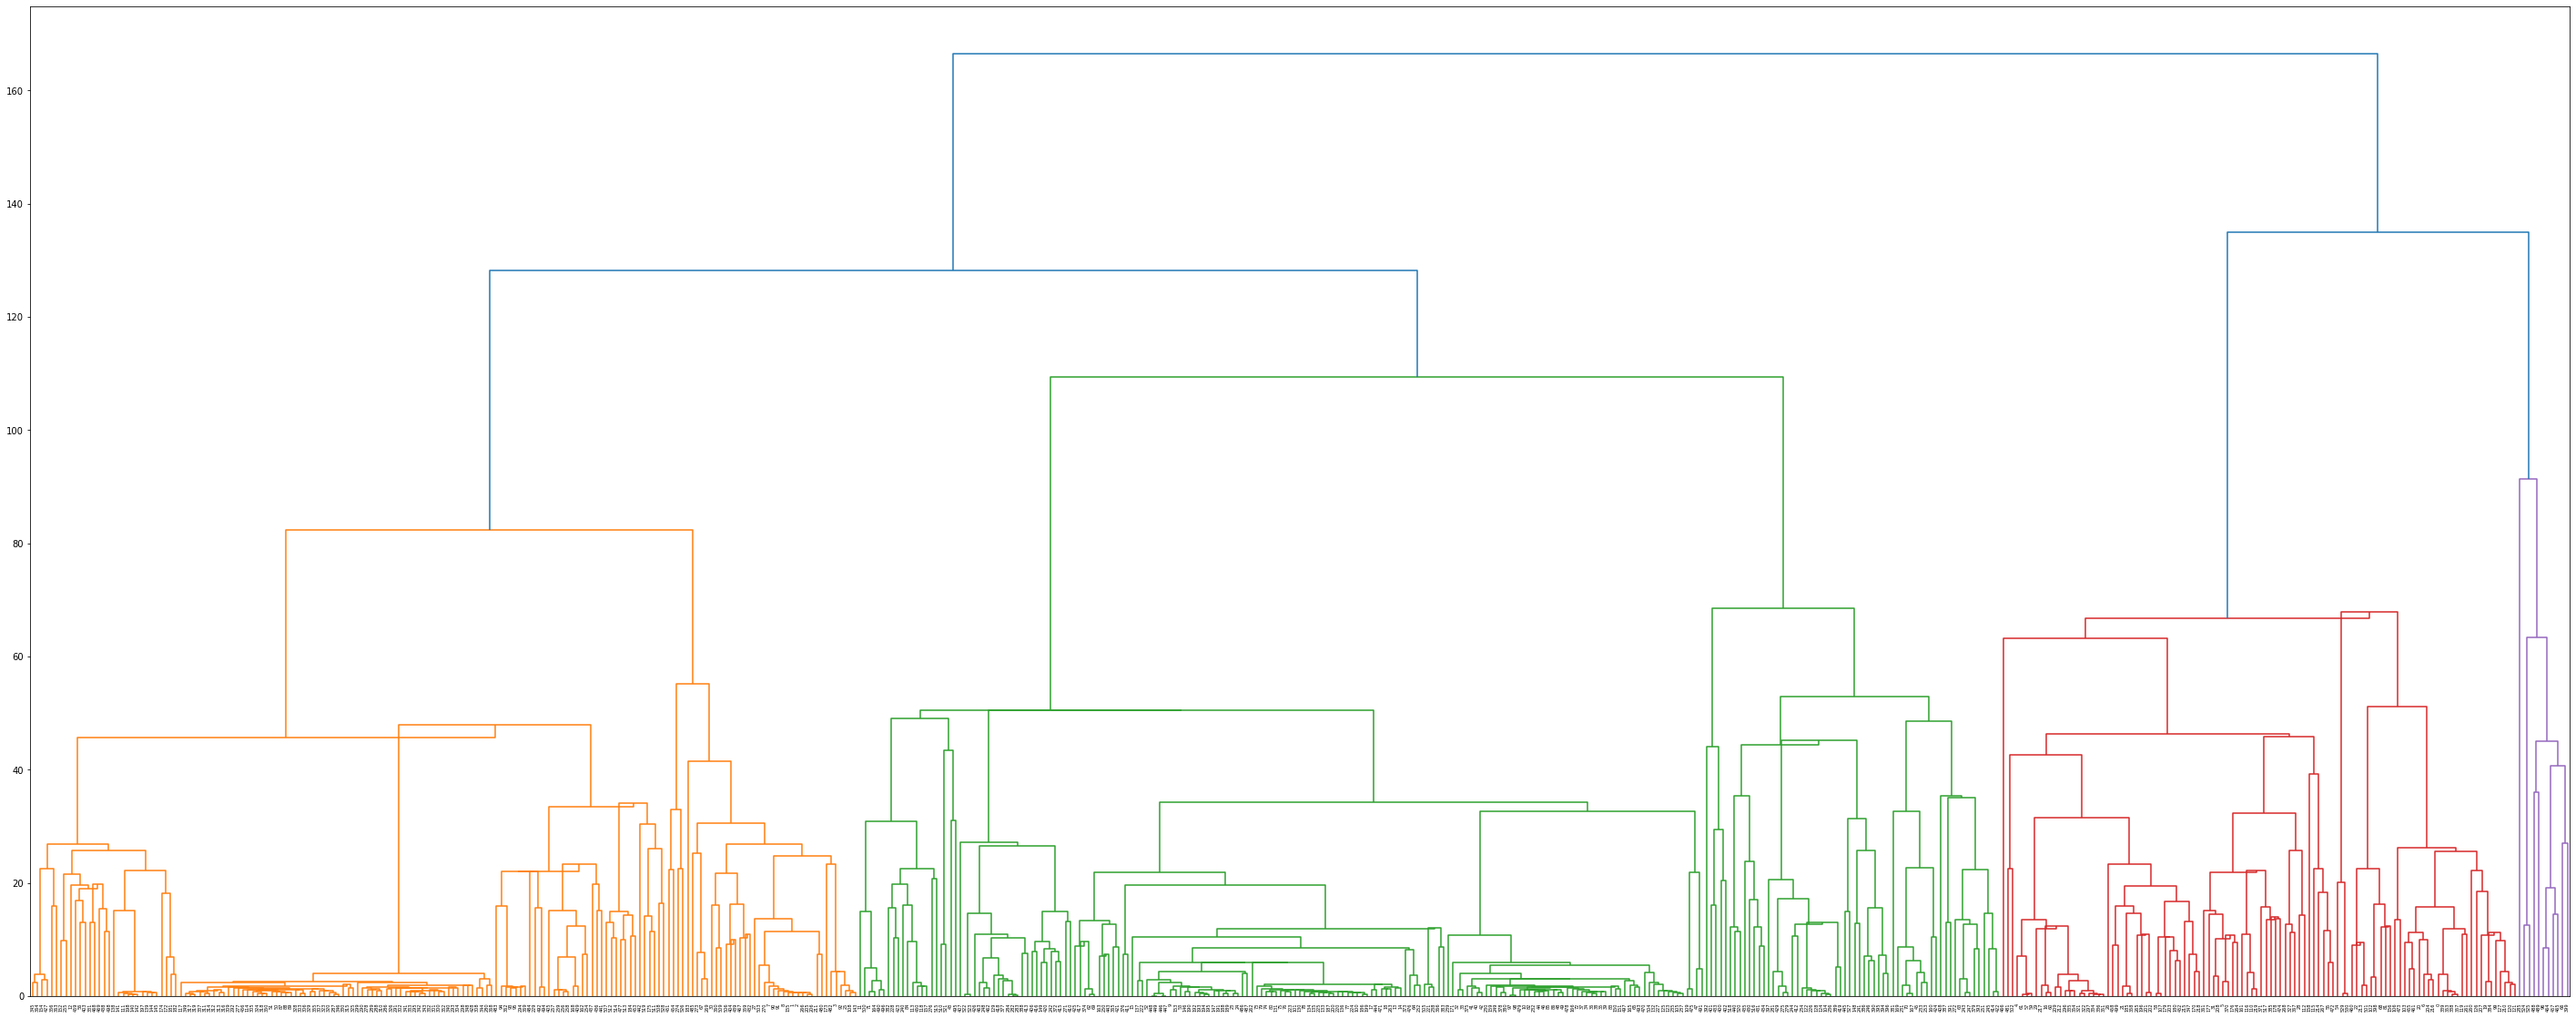

In [20]:
out_centroid = centroid(matrix)
fig = plt.figure(figsize=(50,20))
dn = dendrogram(out_centroid)

In [21]:
l = leaves_list(out_centroid)
tree = to_tree(out_centroid)
##############################
#Split the trees into usable groups
yellow_tree = tree.get_left().get_left()
green_tree = tree.get_left().get_right()
red_tree = tree.get_right()
idx1= yellow_tree.count
idx2= idx1+green_tree.count
grouped_list_centroid = [np.sort(l[:idx1]),np.sort(l[idx1:idx2]),np.sort(l[idx2:])]
n = tree.count
#print(f"grouped_list: {grouped_list}")
statistics(grouped_list_centroid,annotated_dict_list)

------------------------------------------------------------
STATISTICS
------------------------------------------------------------
cluster 0, length: 173
cluster 1, length: 239
cluster 2, length: 119
------------------------------------------------------------
MACRO AVERAGES
------------------------------------------------------------
                 Precision    Recall  F1 score
closed_inactive   0.867052  0.541516  0.666667
open_active       0.623431  0.919753  0.743142
open_inactive     0.134454  0.173913  0.151659
Averages          0.541646  0.545061  0.520489
out:
                            Real closed_inactive  Real open_active  Real open_inactive
Predicted closed_inactive                   150                 6                  17
Predicted open_active                        31               149                  59
Predicted open_inactive                      96                 7                  16
------------------------------------------------------------
MICRO AVERAGES


Centroid is less accurate than ward.

### Centroid CA + CB

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:633: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='centroid', metric='euclidean')


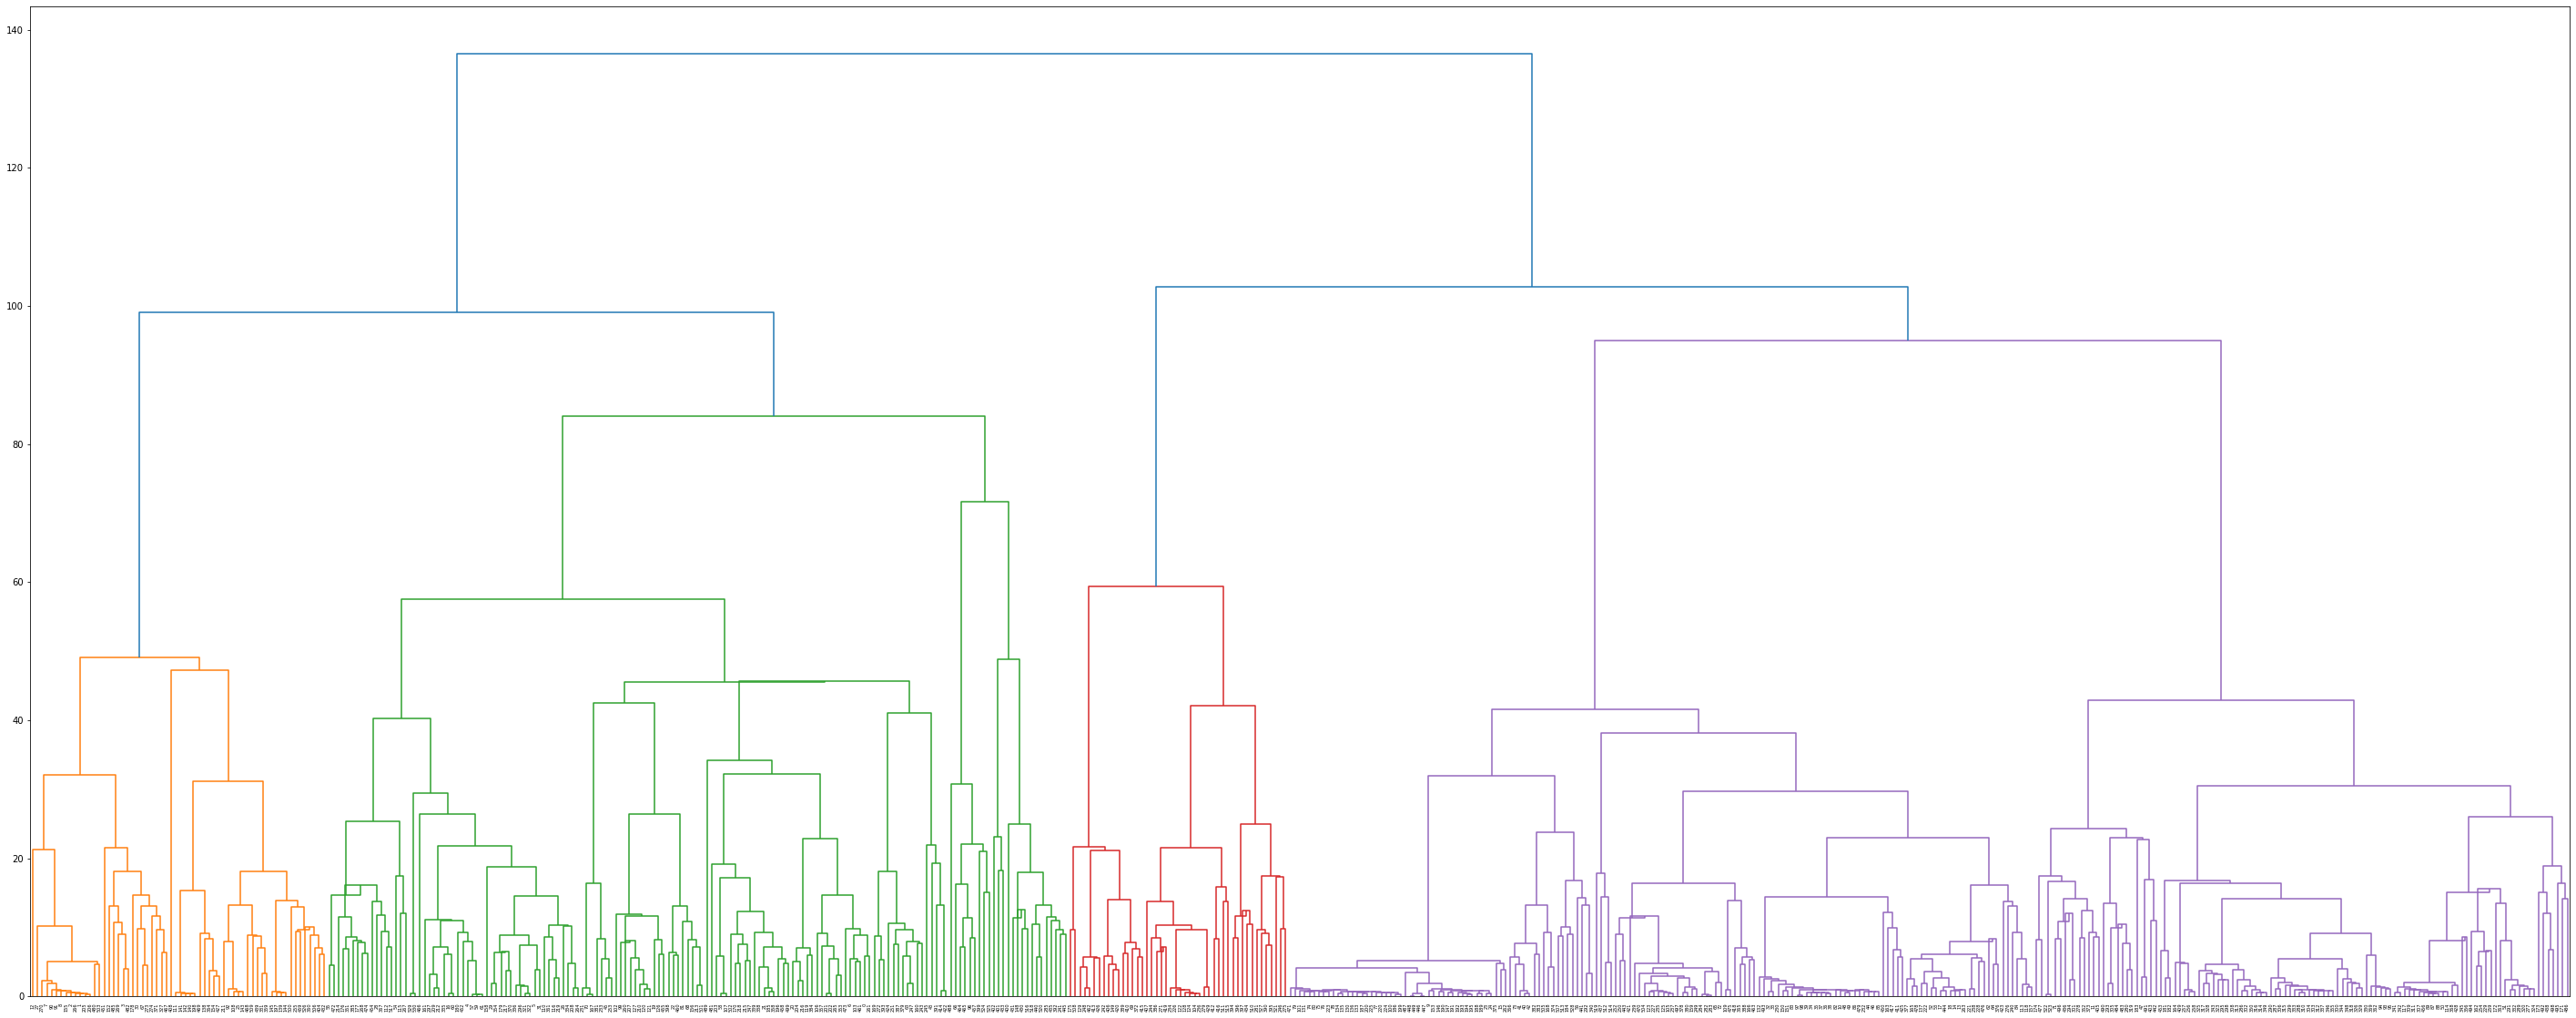

In [22]:
out_centroid_AB = centroid(matrix_AB)
fig = plt.figure(figsize=(50,20))
dn = dendrogram(out_centroid_AB)

In [23]:
l = leaves_list(out_centroid_AB)
tree = to_tree(out_centroid_AB)
##############################
#Split the trees into usable groups
yellow_tree = tree.get_left().get_left()
green_tree = tree.get_left().get_right()
red_tree = tree.get_right()
idx1= yellow_tree.count
idx2= idx1+green_tree.count
grouped_list_centroid = [np.sort(l[:idx1]),np.sort(l[idx1:idx2]),np.sort(l[idx2:])]
n = tree.count
#print(f"grouped_list: {grouped_list}")
statistics(grouped_list_centroid,annotated_dict_list)

------------------------------------------------------------
STATISTICS
------------------------------------------------------------
cluster 0, length: 62
cluster 1, length: 155
cluster 2, length: 314
------------------------------------------------------------
MACRO AVERAGES
------------------------------------------------------------
                 Precision    Recall  F1 score
open_inactive     0.145161  0.097826  0.116883
closed_inactive   0.690323  0.386282  0.495370
open_active       0.404459  0.783951  0.533613
Averages          0.413314  0.422686  0.381956
out:
                            Real open_inactive  Real closed_inactive  Real open_active
Predicted open_inactive                     9                    50                 3
Predicted closed_inactive                  16                   107                32
Predicted open_active                      67                   120               127
------------------------------------------------------------
MICRO AVERAGES
-